In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

Steps:
1 Check target distribution, 2 Explore correlation, 3 Explore target to feature relationships, 4 Handle missing values, 5 Data clean and feature engineer, 6 Model

In [2]:
train = pd.read_csv('../data/raw/train.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.drop(columns=['Id'], inplace=True)

In [5]:
train.shape

(1460, 80)

# Step 1
## Check target distribution


 mu = 180921.20 and sigma = 79415.29



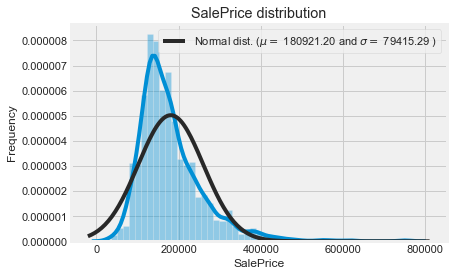

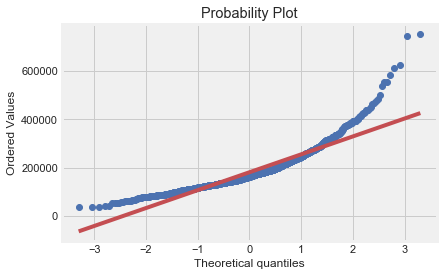

Skewness: 1.882876
Kurtosis: 6.536282


In [6]:
# Plot Histogram
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

### Sales price does not have a normal distribution and skews right

## Step 2
### Check Correlation

In [7]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


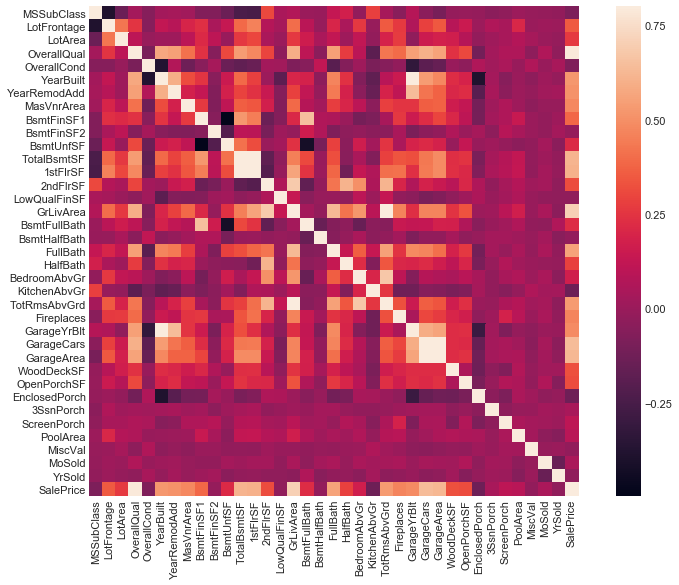

In [8]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

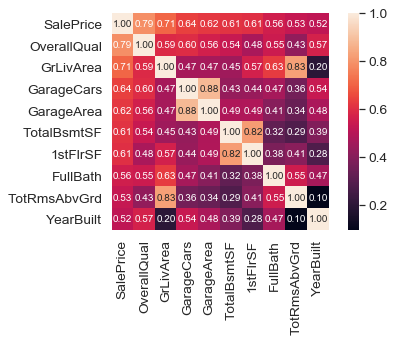

In [9]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [10]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


## Step 3
### Explore relationships further

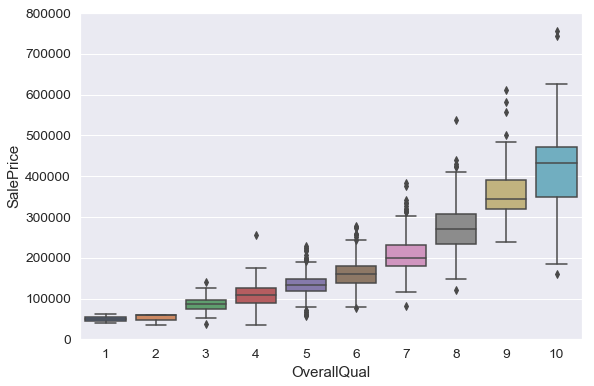

In [11]:
# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

Pearson Coefficient: 0.708624477612652, p_value: 4.518033646780971e-223


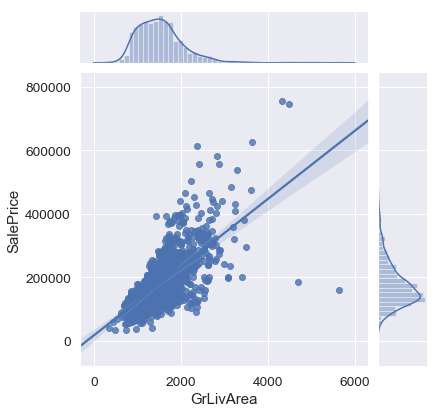

In [12]:
# Living Area vs Sale Price
r_score, p_value = pearsonr(train['GrLivArea'], train['SalePrice'])
print (f'Pearson Coefficient: {r_score}, p_value: {p_value}')
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

In [13]:
# Removing outliers manually (Two points in the bottom right)
train = train.drop(train[(train['GrLivArea']>4000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

Pearson Coefficient: 0.7349681645359327, p_value: 6.59111260363644e-248


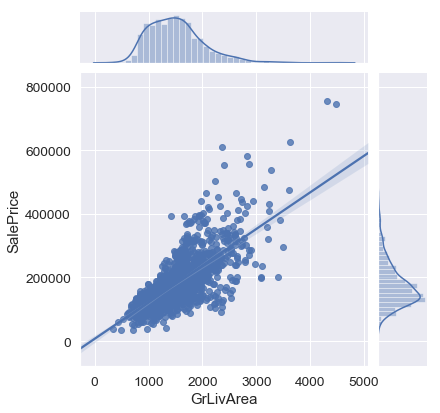

In [14]:
# Living Area vs Sale Price
r_score, p_value = pearsonr(train['GrLivArea'], train['SalePrice'])
print (f'Pearson Coefficient: {r_score}, p_value: {p_value}')
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

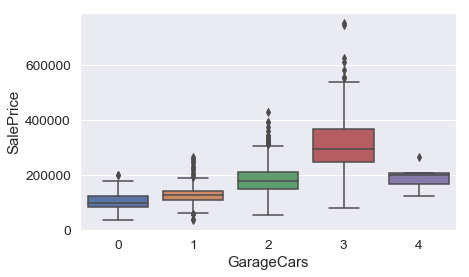

In [15]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

In [16]:
train[train.GarageCars == 4]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
420,90,RM,78.0,7060,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2008,WD,Alloca,206300
746,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979
1189,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1338,20,RL,70.0,8294,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,6,2007,WD,Normal,123000
1348,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000


In [17]:
# Removing outliers manually (More than 4-cars, less than $300k)
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

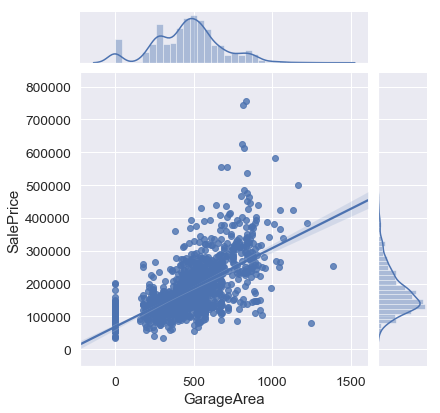

In [18]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

In [19]:
# Removing outliers manually (Two points in the bottom right)
train = train.drop(train[(train['GrLivArea']>4000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

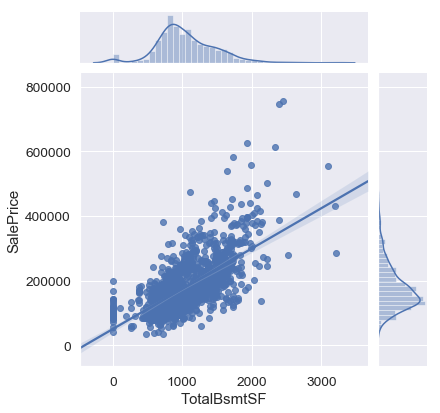

In [20]:
# Total Basement Area vs Sale Price
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

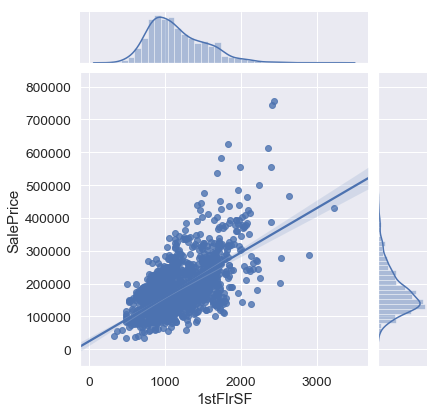

In [21]:
# First Floor Area vs Sale Price
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

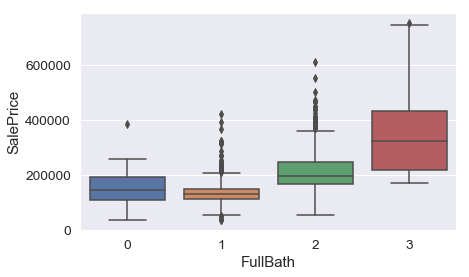

In [22]:
# Number of bathrooms vs Sale Price
sns.boxplot(x=train['FullBath'], y=train['SalePrice'])

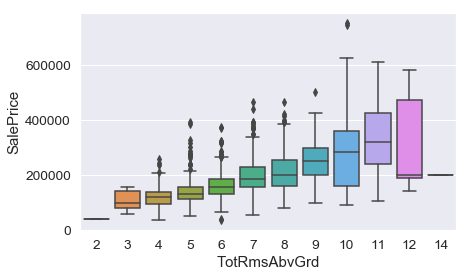

In [23]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])


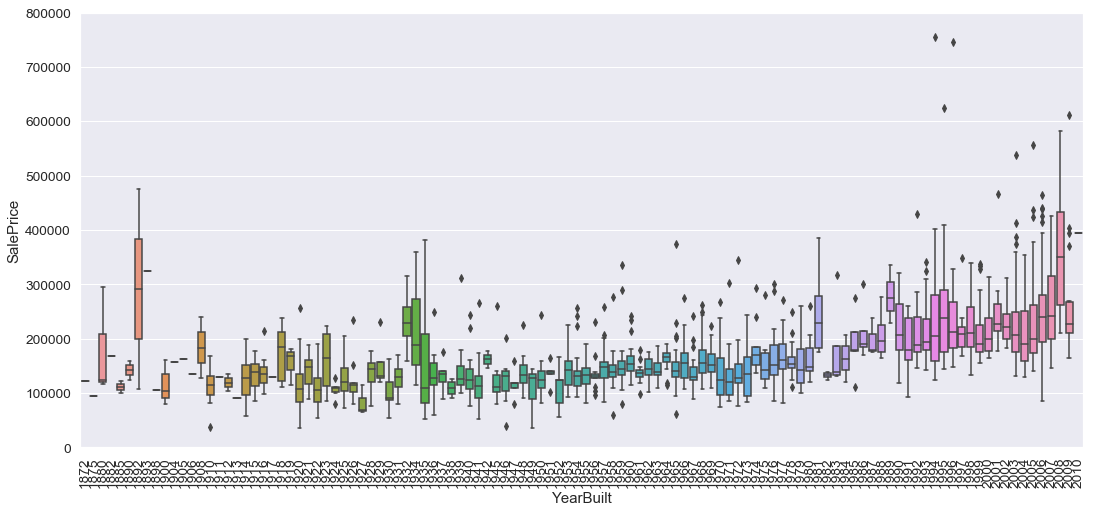

In [24]:
# Year Built vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

## Step 4
### Handle Missing Data

In [25]:
test = pd.read_csv('../data/raw/test.csv')
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (1453, 80)
Test data size is : (1459, 80)
Combined dataset size is : (2912, 80)


In [26]:
num_values = train.shape[0]
pct_missing = [round(train[column].isna().sum()/num_values ,4)*100 for column in train.columns]
missing = pd.DataFrame(index=train.columns, data=pct_missing).sort_values(by=0, ascending=False)

In [27]:
missing

,0
PoolQC,99.59
MiscFeature,96.28
Alley,93.81
Fence,80.73
FireplaceQu,47.28
...,...
Heating,0.00
HeatingQC,0.00
MSZoning,0.00
1stFlrSF,0.00


Text(0.5, 1.0, 'Percent missing data by feature')

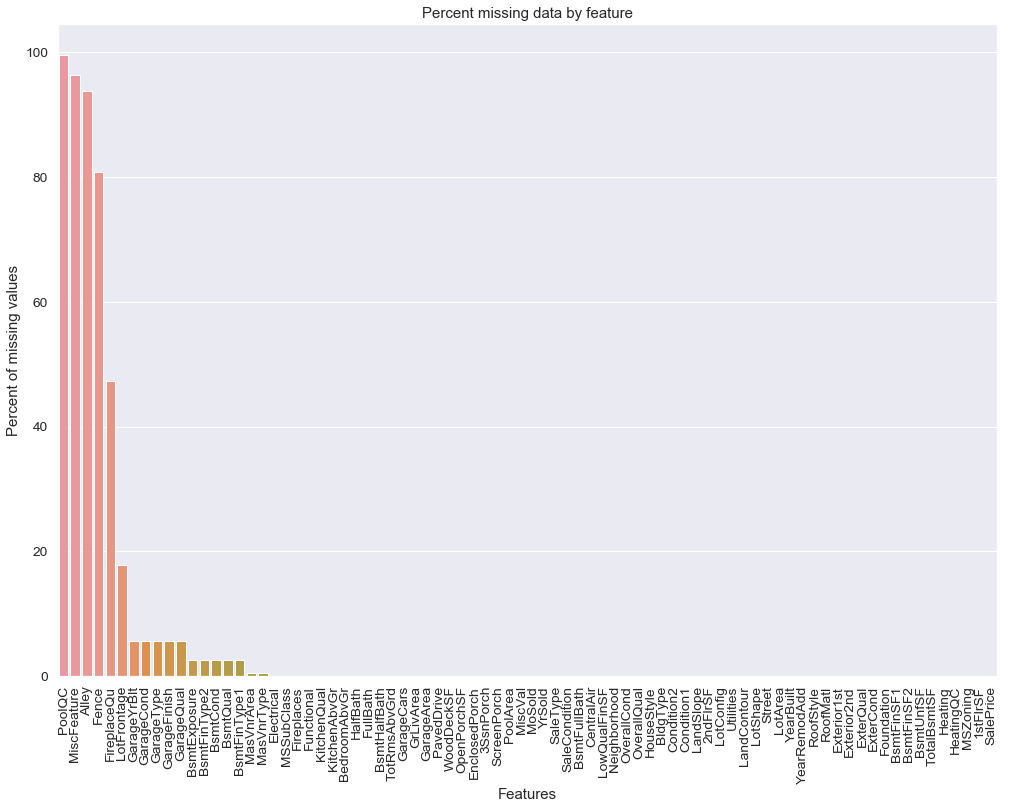

In [28]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing.index, y=missing[0])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [29]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [30]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
Id,49.896978


In [31]:
all_data.drop(columns=['Id'], inplace=True)

In [32]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


## Step 5
### Feature Engineering & Transformation

In [33]:
all_data['MSSubClass'].describe()

count    2912.000000
mean       57.075893
std        42.482345
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

In [34]:
#Convert categorical 'numerical' data accordingly
#MSSubClass =The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [35]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2912, 78)


In [36]:
# Adding Total Square Feet feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


 mu = 12.02 and sigma = 0.40



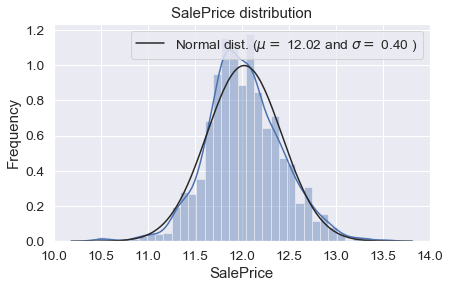

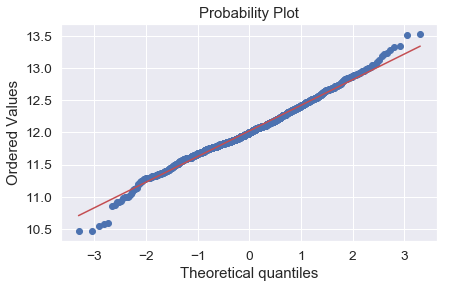

Skewness: 0.123637
Kurtosis: 0.803323


In [37]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

y_train = train.SalePrice.values

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [38]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
MiscVal,21.920854
PoolArea,17.673354
LotArea,13.150188
LowQualFinSF,12.073977
3SsnPorch,11.362112


In [39]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 59 skewed numerical features to Box Cox transform


In [40]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Step 6
### Modeling!

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [69]:
#SIMPLE NUMERIC ONLY MODEL
#y_train = train.pop('SalePrice')
X = train.select_dtypes(include=['int64','float64'])
kf = KFold(n_splits=3)
c = 1
coefs = []
#base_mean_error = mean_squared_error
for train_index, test_index in kf.split(X):
    y_act = y_train[test_index]
    
    clf = LinearRegression()
    clf.fit(X.iloc[train_index], y_train[train_index])
    coefs.append(clf.coef_)
    
    y_pred = clf.predict(X.iloc[test_index])
    rmse = mean_squared_error(y_act, y_pred)
    base_error = mean_squared_error(y_act, np.full(y_act.shape, y_act.mean()))
    print (f'KFOLD {c} rmse: {rmse}')
    print (f'BASE ERROR      : {base_error}')
    c += 1

KFOLD 1 rmse: 0.014044166302080989
BASE ERROR      : 0.162703346201694
KFOLD 2 rmse: 0.017843658770343506
BASE ERROR      : 0.16745701134690463
KFOLD 3 rmse: 0.014173239513124334
BASE ERROR      : 0.1493895181219437


In [73]:
for column, i in zip(X.columns, range(len(X.columns))):
    print (column, np.mean([coef[i] for coef in coefs]))


1stFlrSF -0.0016768566959220685
2ndFlrSF -0.0017983235723460546
3SsnPorch 0.00021091236639752634
Alley 0.054664297579580044
BedroomAbvGr -0.04235193321518366
BsmtCond 0.016827801718016913
BsmtExposure -0.009660547948241166
BsmtFinSF1 0.004809796396146807
BsmtFinSF2 -0.0030313139367684878
BsmtFinType1 0.0015629503994404742
BsmtFinType2 -0.009687583002577915
BsmtFullBath 0.038324116803736236
BsmtHalfBath -0.00263968891442643
BsmtQual -0.042197868035937745
BsmtUnfSF -0.003219009080294289
CentralAir 0.059656592925140826
EnclosedPorch 0.0015805325647296777
ExterCond 0.01630648223763164
ExterQual -0.07154789453852944
Fence 0.007651192181940297
FireplaceQu -0.014622459817510031
Fireplaces 0.04098524068736251
FullBath 0.05191019566233798
Functional 0.057816253786210685
GarageArea 0.012669433365808521
GarageCars 0.055079824798910104
GarageCond 0.008913789781546185
GarageFinish -0.0020795389812442444
GarageQual -0.004569289252852581
GarageYrBlt -0.00701203444192694
GrLivArea 0.059817449976925195

(array([ 1.,  0.,  0.,  1.,  3.,  3.,  4.,  4., 11., 11., 21., 33., 42.,
        40., 36., 35., 41., 36., 38., 25., 30., 19., 14., 13.,  5.,  8.,
         5.,  1.,  1.,  3.]),
 array([10.73282672, 10.81372675, 10.89462678, 10.97552681, 11.05642684,
        11.13732687, 11.2182269 , 11.29912693, 11.38002696, 11.46092699,
        11.54182702, 11.62272705, 11.70362708, 11.78452711, 11.86542714,
        11.94632717, 12.0272272 , 12.10812723, 12.18902726, 12.26992729,
        12.35082732, 12.43172735, 12.51262738, 12.59352741, 12.67442744,
        12.75532747, 12.8362275 , 12.91712753, 12.99802756, 13.07892759,
        13.15982762]),
 <a list of 30 Patch objects>)

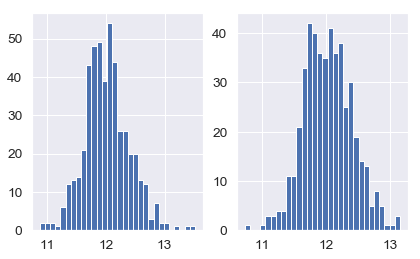

In [61]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(y_act, bins=30)
axes[1].hist(y_pred, bins=30)

In [59]:
#STANDARD SCALER ATTEMPT
kf = KFold(n_splits=3)
c = 1
#base_mean_error = mean_squared_error
for train_index, test_index in kf.split(X):
    y_act = y_train[test_index]
    
    X_train = StandardScaler().fit_transform(X.iloc[train_index].values)

    clf = LinearRegression()
    clf.fit(X_train, y_train[train_index])
    
    y_pred = clf.predict(StandardScaler().fit_transform(X.iloc[test_index]))
    rmse = mean_squared_error(np.expm1(y_act), np.expm1(y_pred))
    base_error = mean_squared_error(np.expm1(y_act), np.full(y_act.shape, np.expm1(y_act.mean())))
    print (f'KFOLD {c} rmse: {rmse}')
    print (f'BASE ERROR      : {base_error}')
    c += 1

KFOLD 1 rmse: 527045135.0260876
BASE ERROR      : 6324541078.932258
KFOLD 2 rmse: 684769652.0586259
BASE ERROR      : 7015421183.703067
KFOLD 3 rmse: 590195831.9377904
BASE ERROR      : 6244674163.367887


In [44]:
from sklearn.preprocessing import OneHotEncoder

In [63]:
#INCORPORATE ALL DATA WITH OHE
X = train.copy()
cats = X.select_dtypes(include=['object'])
#cats = np.array(range(X.shape[1]))[X.columns.isin(cats.columns)
ohe = OneHotEncoder(drop='first', sparse=False)

In [64]:
X = ohe.fit_transform(X)

In [65]:
 kf = KFold(n_splits=3)
c = 1
#base_mean_error = mean_squared_error
for train_index, test_index in kf.split(X):
    y_act = y_train[test_index]
    
    clf = LinearRegression()
    clf.fit(X[train_index], y_train[train_index])
    y_pred = clf.predict(X[test_index])
    rmse = mean_squared_error(y_act, y_pred)
    base_error = mean_squared_error(y_act, np.full(y_act.shape, y_act.mean()))
    print (f'KFOLD {c} rmse: {rmse}')
    print (f'BASE ERROR      : {base_error}')
    c += 1

KFOLD 1 rmse: 0.024342322302878697
BASE ERROR      : 0.162703346201694
KFOLD 2 rmse: 0.026984828530378167
BASE ERROR      : 0.16745701134690463
KFOLD 3 rmse: 0.01936545966598525
BASE ERROR      : 0.1493895181219437


(array([ 3.,  1.,  2.,  3.,  5., 11.,  8., 10., 15., 25., 27., 37., 40.,
        31., 29., 28., 37., 34., 25., 22., 19., 19., 11.,  8., 12.,  5.,
         9.,  3.,  2.,  3.]),
 array([11.01180588, 11.0785646 , 11.14532332, 11.21208205, 11.27884077,
        11.3455995 , 11.41235822, 11.47911694, 11.54587567, 11.61263439,
        11.67939311, 11.74615184, 11.81291056, 11.87966929, 11.94642801,
        12.01318673, 12.07994546, 12.14670418, 12.2134629 , 12.28022163,
        12.34698035, 12.41373907, 12.4804978 , 12.54725652, 12.61401525,
        12.68077397, 12.74753269, 12.81429142, 12.88105014, 12.94780886,
        13.01456759]),
 <a list of 30 Patch objects>)

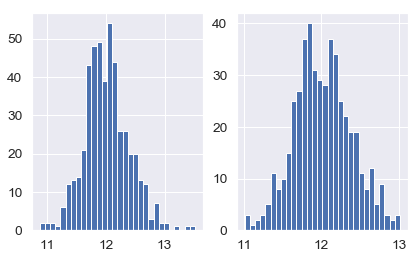

In [66]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(y_act, bins=30)
axes[1].hist(y_pred, bins=30)

In [55]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])